## Test parallel firehose instabilities

###### Gary et al. Proton temperature anisotropy instabilities in the solar wind, JGR 1976

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.parallel_mode import parallel_em_wave_wrapper
from py_vlasov.util import real_imag, list_to_complex
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
k=0.1
betap = 1.
t_list=[1.,1.]
#a_list=[0.6,0.]
a_list=[0., 0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]

In [33]:
f = lambda wrel: real_imag(parallel_em_wave_wrapper(wrel[0] + 1j * wrel[1], k, betap, t_list, \
                                                      a_list, n_list, q_list, \
                                                      m_list, v_list, method = 'pade', aol=1/5000, mode = 'r'))
#guess = k * np.sqrt(abs(1/betap - a_list[0]/2 - t_list[1] * a_list[1]/2)) 
#print('guess = ', guess)
guess = 0.1
freq = scipy.optimize.fsolve(f, real_imag(guess))
print(freq)

[  1.07277486e-01  -5.77446472e-09]


In [6]:
def simple_follow_fn(prev_result, prev_param_val, cur_param_val):
    """
    Follow a solution by using the previous result directly as a guess for \
    the new result.

    """
    return prev_result

In [7]:
def change_k(seed_freq, param, target_k, num_step, follow_k_fn=simple_follow_fn, step_method = 'log',  show_plot=True):
    """
    Follow the solution and incrementally change angles to the target_angle.
    
    Parameters
    ----------
    freq: w/proton_gyro_frequency
    param: list (k, theta, beta, te/tp, method, mratio, n, aol)
    wrel, k, betap, t_list, a_list, n_list, q_list,
                             m_list, v_list, method = 'pade', aol=1/5000, mode='r'
    target_angle: target propogation angle
    num_step: number of steps
    follow_beta_fn: how to follow from one beta to another beta
    show_plot: whether to show a plot of intermediate steps
    Return
    ------
    freq at the target angle
    """
    seed_k, betap, t_list, a_list, n_list, q_list, \
    m_list, v_list, method, aol, mode = param
    start = seed_k
    stop = target_k
    if step_method == 'log':
        k_list = np.logspace(np.log10(start), np.log10(stop), num_step, endpoint=True)
    else:
        k_list = np.linspace(start, stop, num_step, endpoint=True)
    result = [seed_freq]
    for i in list(range(num_step))[1:]:
        k = k_list[i]
        prev_k = k_list[i-1]
        prev_result = result[-1]
        guess = follow_k_fn(prev_result, prev_k, k)
        f = lambda wrel: real_imag(parallel_em_wave_wrapper(wrel[0] + 1j * wrel[1], k, betap, t_list, \
                                                            a_list, n_list, q_list, \
                                                            m_list, v_list, method = method, aol=aol))
        freq = scipy.optimize.fsolve(f, real_imag(guess))
        result += [list_to_complex(freq)]

    if show_plot:
        plt.plot(k_list, np.real(result), 'o-', markersize= 2)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$k\rho_p$')
        plt.ylabel(r'$\omega/\Omega_{ci}$')
        plt.title(r'Change $k\rho_p$ from {0} to {1}'.format(seed_k, target_k))
        plt.show()
    return k_list, result


### Without anisotropy

In [49]:
seed_freq = 1.07277486e-01  - 5.77446472e-09j
target_k = 1.0
num_step = 100
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
#a_list=[0,0.]
a_list=[0.,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'r'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [50]:
i_k_list, i_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
i_w_list = np.array(i_w_list)

### with anisotropy

In [51]:
seed_freq = 9.23496910e-02 + 3.52557188e-08j
target_k = 1.0
num_step = 100
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
#a_list=[0,0.]
a_list=[0.6,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'r'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [52]:
a_k_list, a_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
a_w_list = np.array(w_list)

(0, 1.7)

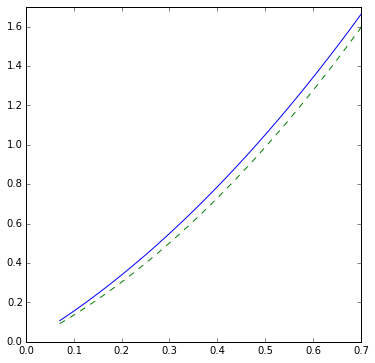

In [53]:
plt.figure(figsize=[6,6])
plt.plot(i_k_list/np.sqrt(2), np.real(i_w_list))
plt.plot(a_k_list/np.sqrt(2), np.real(a_w_list), '--')
plt.xlim([0, 0.7])
plt.ylim([0, 1.7])

(1e-06, 0.0004)

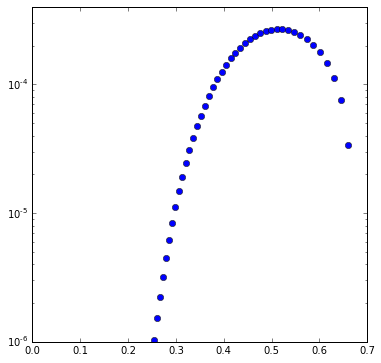

In [55]:
plt.figure(figsize=[6,6])
#plt.plot(k_list/np.sqrt(2), np.real(w_list))
plt.plot(a_k_list/np.sqrt(2), np.imag(a_w_list), 'o')
plt.xlim([0, 0.7])
plt.yscale('log')
plt.ylim([1e-6, 4e-4])
#plt.ylim([0, 1.7])